In [ ]:
import pandas as pd

df = pd.read_excel("/content/Telco_customer_churn.xlsx")




In [ ]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [ ]:
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")

#Заполним NaN используя логику Total Charges = Monthly Charges * Tenure Months
mask = df["Total Charges"].isna()
df.loc[mask, "Total Charges"] = df.loc[mask, "Monthly Charges"] * df.loc[mask, "Tenure Months"]
print("NaN в Total Charges после обработки:", df["Total Charges"].isna().sum())

NaN в Total Charges после обработки: 0


In [ ]:

drop_cols = ["CustomerID", "Country", "State", "City", "Zip Code", "Lat Long"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")
print("Удалены колонки:", drop_cols)
print("NEW shape:", df.shape)


Удалены колонки: ['CustomerID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long']
NEW shape: (7043, 27)


In [ ]:
# Проверим целевую переменную
print("Распределение Churn Value:\n", df["Churn Value"].value_counts())


Распределение Churn Value:
 Churn Value
0    5174
1    1869
Name: count, dtype: int64


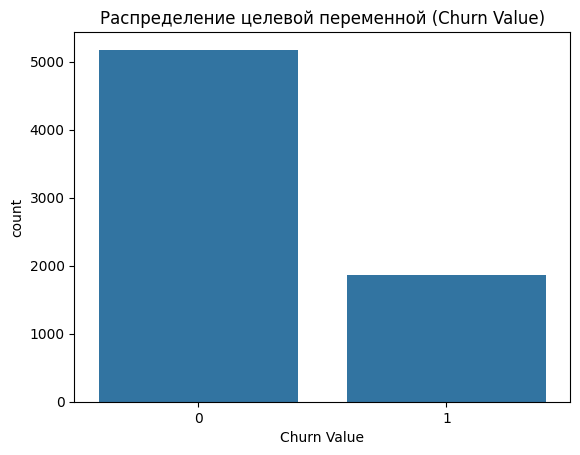

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Распределение целевой переменной
sns.countplot(x="Churn Value", data=df)
plt.title("Распределение целевой переменной (Churn Value)")
plt.show()

Числовые признаки: ['Count', 'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score', 'CLTV']


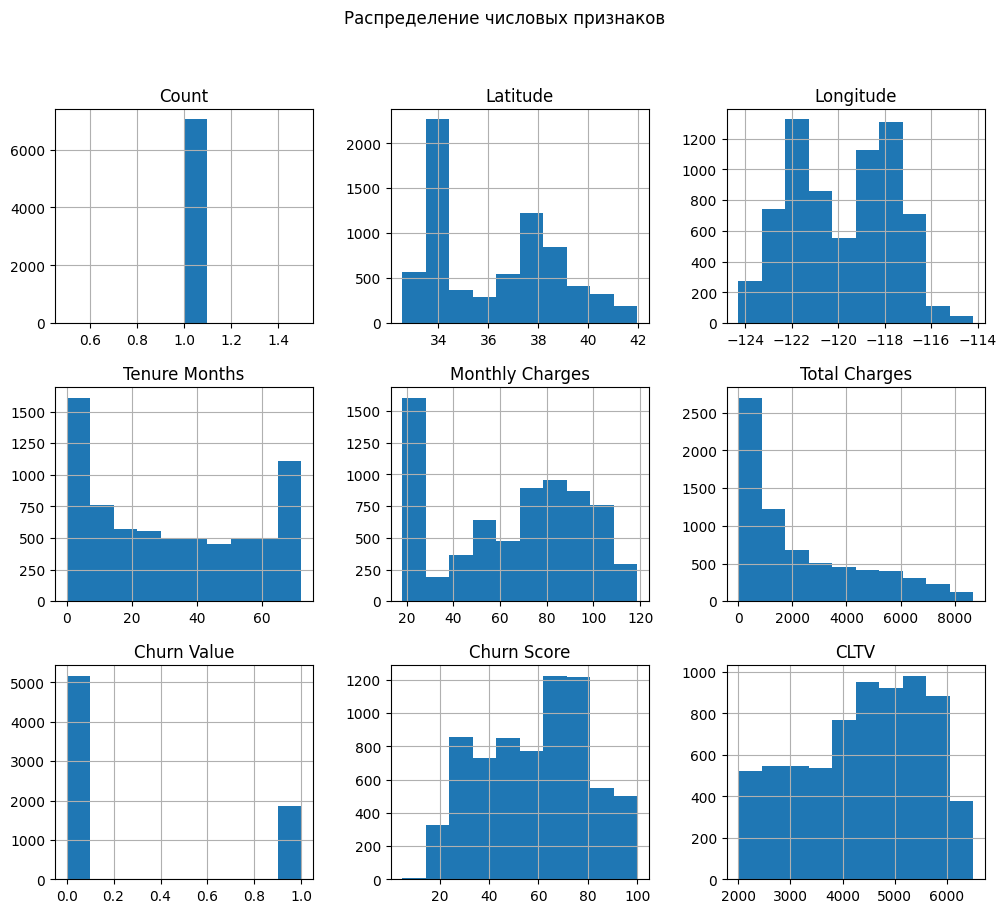

In [ ]:

#Проверим числовые признаки
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Числовые признаки:", num_cols)

df[num_cols].hist(figsize=(12, 10))
plt.suptitle("Распределение числовых признаков")
plt.show()


Категориальные признаки: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection'] ...


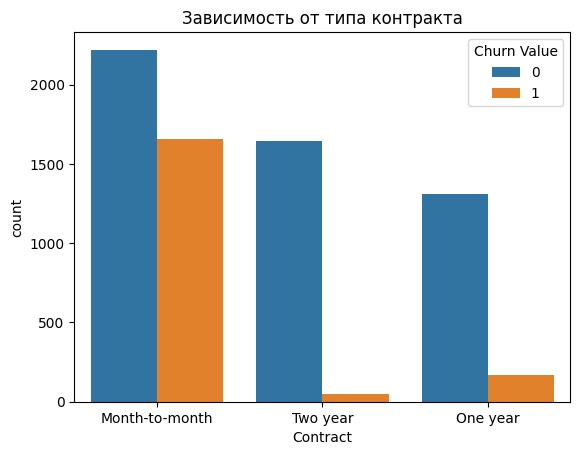

In [ ]:

#Проверим категориальные признаки
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Категориальные признаки:", cat_cols[:10])

# Пример: Contract vs Churn
sns.countplot(x="Contract", hue="Churn Value", data=df)
plt.title("Зависимость от типа контракта")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(["Churn Value", "Churn Label", "Churn Score", "CLTV", "Churn Reason"], axis=1)
y = df["Churn Value"]

num_cols = ['Count', 'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges']
cat_cols = [col for col in X.columns if col not in num_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)
print("Форма X после One-Hot Encoding и нормализации:", X_transformed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

#Метрики
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Форма X после One-Hot Encoding и нормализации: (7043, 33)
Accuracy: 0.8019872249822569
Precision: 0.6426426426426426
Recall: 0.5721925133689839
F1-score: 0.6053748231966054
ROC-AUC: 0.8480560076468004


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Лучшие параметры RandomForest:", grid_rf.best_params_)

y_pred_rf = grid_rf.predict(X_test)
y_prob_rf = grid_rf.predict_proba(X_test)[:,1]

print("RandomForest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RandomForest - Precision:", precision_score(y_test, y_pred_rf))
print("RandomForest - Recall:", recall_score(y_test, y_pred_rf))
print("RandomForest - F1-score:", f1_score(y_test, y_pred_rf))
print("RandomForest - ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Лучшие параметры RandomForest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest - Accuracy: 0.8062455642299503
RandomForest - Precision: 0.6711864406779661
RandomForest - Recall: 0.5294117647058824
RandomForest - F1-score: 0.5919282511210763
RandomForest - ROC-AUC: 0.8500297088532381


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Лучшие параметры XGBoost:", grid_xgb.best_params_)

y_pred_xgb = grid_xgb.predict(X_test)
y_prob_xgb = grid_xgb.predict_proba(X_test)[:,1]

print("XGBoost - Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost - Precision:", precision_score(y_test, y_pred_xgb))
print("XGBoost - Recall:", recall_score(y_test, y_pred_xgb))
print("XGBoost - F1-score:", f1_score(y_test, y_pred_xgb))
print("XGBoost - ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


Лучшие параметры XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBoost - Accuracy: 0.8019872249822569
XGBoost - Precision: 0.6557377049180327
XGBoost - Recall: 0.5347593582887701
XGBoost - F1-score: 0.5891016200294551
XGBoost - ROC-AUC: 0.849035108114392


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:08:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

cat = CatBoostClassifier(random_state=42, verbose=0)

param_grid_cat = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_cat = GridSearchCV(cat, param_grid_cat, cv=3, scoring='f1', n_jobs=-1)
grid_cat.fit(X_train, y_train)

print("Лучшие параметры CatBoost:", grid_cat.best_params_)

y_pred_cat = grid_cat.predict(X_test)
y_prob_cat = grid_cat.predict_proba(X_test)[:,1]

print("CatBoost - Accuracy:", accuracy_score(y_test, y_pred_cat))
print("CatBoost - Precision:", precision_score(y_test, y_pred_cat))
print("CatBoost - Recall:", recall_score(y_test, y_pred_cat))
print("CatBoost - F1-score:", f1_score(y_test, y_pred_cat))
print("CatBoost - ROC-AUC:", roc_auc_score(y_test, y_prob_cat))


Лучшие параметры CatBoost: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
CatBoost - Accuracy: 0.8026969481902059
CatBoost - Precision: 0.6589403973509934
CatBoost - Recall: 0.5320855614973262
CatBoost - F1-score: 0.5887573964497042
CatBoost - ROC-AUC: 0.8557131416466455


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

rf_best = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=2, random_state=42
)

xgb_best = XGBClassifier(
    n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)

cat_best = CatBoostClassifier(
    iterations=100, depth=4, learning_rate=0.1, l2_leaf_reg=5,
    verbose=0, random_state=42
)

stack = StackingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best), ('cat', cat_best)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3,
    n_jobs=-1
)

stack.fit(X_train, y_train)

y_pred_stack = stack.predict(X_test)
y_prob_stack = stack.predict_proba(X_test)[:,1]

print("Stacking - Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking - Precision:", precision_score(y_test, y_pred_stack))
print("Stacking - Recall:", recall_score(y_test, y_pred_stack))
print("Stacking - F1-score:", f1_score(y_test, y_pred_stack))
print("Stacking - ROC-AUC:", roc_auc_score(y_test, y_prob_stack))


Stacking - Accuracy: 0.8041163946061036
Stacking - Precision: 0.6633333333333333
Stacking - Recall: 0.5320855614973262
Stacking - F1-score: 0.5905044510385756
Stacking - ROC-AUC: 0.8538737761244155


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from sklearn.ensemble import RandomForestClassifier, StackingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier


# X = df.drop("Churn Value", axis=1)
# y = df["Churn Value"]

# X = pd.get_dummies(X, drop_first=True)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )


# rf = RandomForestClassifier(random_state=42)
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# cat = CatBoostClassifier(verbose=0, random_state=42)


# stack = StackingClassifier(
#     estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
#     final_estimator=LogisticRegression(max_iter=1000),
#     cv=3,
#     n_jobs=-1
# )

# param_grid_stack = {
#     'rf__n_estimators': [100, 200],
#     'rf__max_depth': [10, 20],
#     'xgb__max_depth': [3, 5],
#     'xgb__learning_rate': [0.05, 0.1],
#     'cat__depth': [4, 6],
#     'cat__learning_rate': [0.05, 0.1]
# }


# grid_stack = GridSearchCV(stack, param_grid_stack, cv=3, scoring='f1', n_jobs=-1)
# grid_stack.fit(X_train, y_train)


# print("Лучшие параметры Stacking:", grid_stack.best_params_)

# y_pred_stack_best = grid_stack.predict(X_test)
# y_prob_stack_best = grid_stack.predict_proba(X_test)[:,1]

# print("Stacking (Grid) - Accuracy:", accuracy_score(y_test, y_pred_stack_best))
# print("Stacking (Grid) - Precision:", precision_score(y_test, y_pred_stack_best))
# print("Stacking (Grid) - Recall:", recall_score(y_test, y_pred_stack_best))
# print("Stacking (Grid) - F1-score:", f1_score(y_test, y_pred_stack_best))
# print("Stacking (Grid) - ROC-AUC:", roc_auc_score(y_test, y_prob_stack_best))
